# Sampling

GP emulation of 6S for a single wavelength with different input samplings

**Author:** Brian Schubert &lt;<schubert.b@northeastern.edu>&gt;

**Date:** 29 August 2023

In [177]:
import itertools
import math
import pathlib
from typing import Final

import alive_progress
import matplotlib.pyplot as plt
import numpy as np
import rtm_wrapper.parameters as rtm_param
import scipy.stats.qmc as sci_qmc
import sklearn.base as skl_base
import sklearn.gaussian_process as skl_gp
import sklearn.pipeline
import sklearn.preprocessing as skl_pre
import xarray as xr
from rtm_wrapper.engines.sixs import PySixSEngine, pysixs_default_inputs
from rtm_wrapper.execution import ConcurrentExecutor
from rtm_wrapper.simulation import SweepSimulation

from scratch_emulator import brute_maximin, sweep_hash


def unit2range(arr: np.ndarray, bot: float, top: float) -> np.ndarray:
    return arr * (top - bot) + bot

## Set wavelengths and input parameter ranges

In [178]:
# Fixed wavelength to simulate.
# WAVELENGTHS: Final = [0.570, 0.590, 0.630, 0.6475]  # micrometers
WAVELENGTH: Final = 0.570  # micrometers

# Atmosphere parameter ranges to simulate.
OZONE_RANGE: Final = (0.25, 0.45)  # cm-atm
WATER_RANGE: Final = (1, 4)  # g/cm^2
AOT_RANGE: Final = (0.05, 0.5)  # 1
# TARGET_ALT_RANGE: Final = (0.1, 30)  # km
ZENITH_RANGE: Final = (10, 60)  # degrees

INPUT_RANGES: Final = {
    "atmosphere.ozone": OZONE_RANGE,
    "atmosphere.water": WATER_RANGE,
    "aerosol_profile.aot": AOT_RANGE,
    # "altitude_target.value": TARGET_ALT_RANGE,
    # "geometry.solar_zenith": ZENITH_RANGE,
}

# Model output to emulate.
target_output: Final = "total_transmission"

## Define base 6S inputs

In [179]:
base_inputs = pysixs_default_inputs().replace(
    atmosphere=rtm_param.AtmosphereWaterOzone(),
    aerosol_profile=rtm_param.AerosolAOTSingleLayer(profile="Maritime", height=100),
    # altitude_target=rtm_param.AltitudeKilometers(),
    wavelength__value=WAVELENGTH,
)


def param_rich_name(param_name: str) -> str:
    meta = base_inputs.get_metadata(param_name)
    return f"{meta.get('title', param_name)} (${meta.get('unit', '?')}$)"

# Run true 6S simulation

## Sample atmosphere input ranges

In [180]:
# Number of LHS samples to draw.
NUM_SAMPLES: Final = 20

# Setup sampler
rng = np.random.default_rng(2023_09_01_1)

lhs_sampler = sci_qmc.LatinHypercube(d=len(INPUT_RANGES), seed=rng)

samplers = {
    "uniform": lambda n: rng.uniform(size=(n, len(INPUT_RANGES))),
    "lhs": lhs_sampler.random,
    "maximin": lambda n: brute_maximin(
        n, len(INPUT_RANGES), iterations=10_000, pick="min", metric="euclidean", rng=rng
    ),  # metric=lambda u,v: np.min(np.abs(u-v))
}

# Draw LHS samples for each band. Rescale samples to parameter ranges.
sampler_input_samples: list[np.ndarray] = []
for sampler in samplers.values():
    raw_samples = sampler(NUM_SAMPLES)

    rescaled_samples = {
        input_name: unit2range(raw_samples[:, sample_column], *input_range)
        for sample_column, (input_name, input_range) in enumerate(INPUT_RANGES.items())
    }
    sampler_input_samples.append(rescaled_samples)

## Plot atmosphere input samples

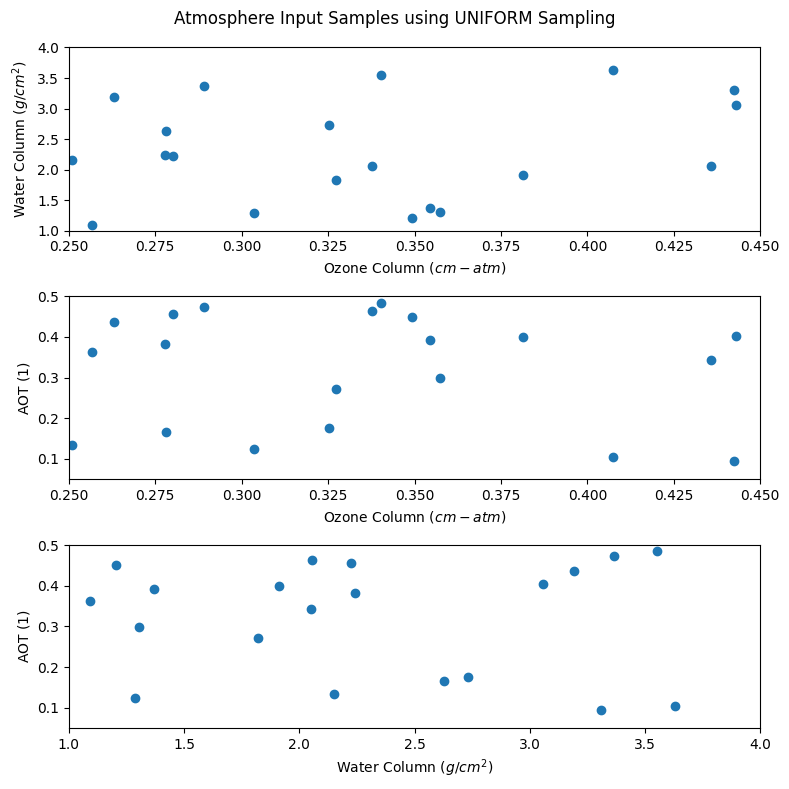

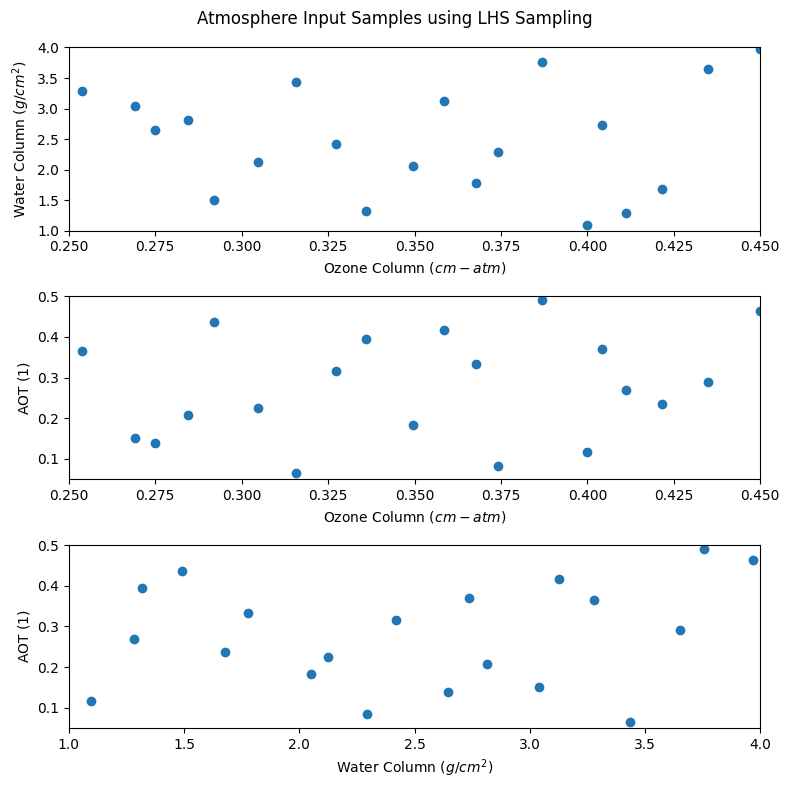

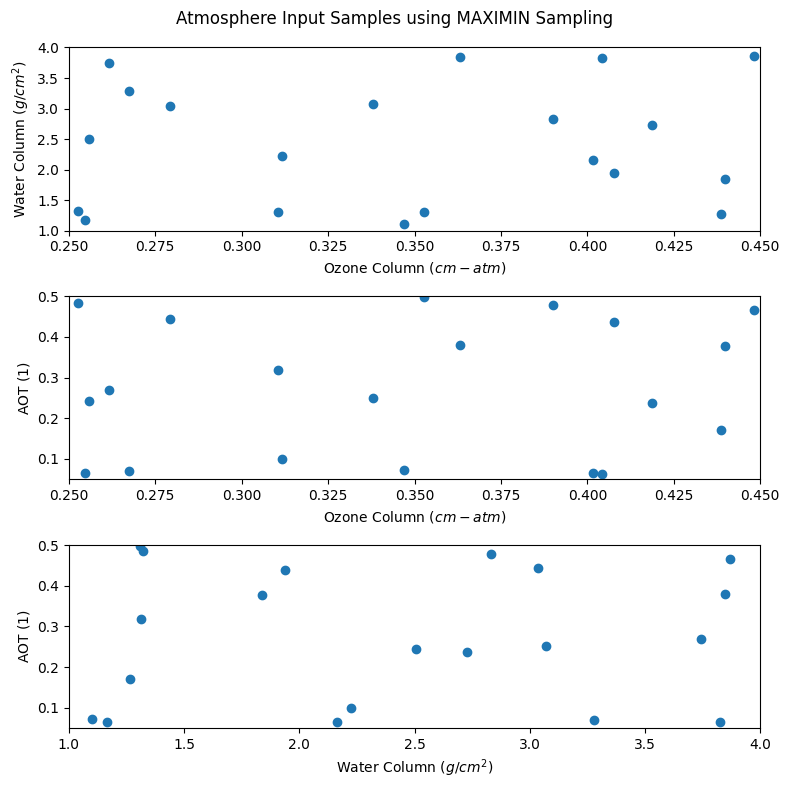

In [181]:
for sampler_name, input_samples in zip(samplers, sampler_input_samples):
    param_combos = list(itertools.combinations(INPUT_RANGES.keys(), r=2))
    ncols = math.floor(math.sqrt(len(param_combos)))
    nrows = math.ceil(len(param_combos) / ncols)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8))
    axs = np.asarray(axs)

    for ax, (param_x, param_y) in zip(axs.flat, param_combos):
        ax.scatter(input_samples[param_x], input_samples[param_y])
        ax.set_xlim(INPUT_RANGES[param_x])
        ax.set_ylim(INPUT_RANGES[param_y])
        ax.set_xlabel(param_rich_name(param_x))
        ax.set_ylabel(param_rich_name(param_y))

    fig.suptitle(f"Atmosphere Input Samples using {sampler_name.upper()} Sampling")
    fig.tight_layout()

## Perform simulation

In [182]:
sampler_train_outputs: list[xr.DataArray] = []

for input_samples in sampler_input_samples:
    sweep = SweepSimulation(
        {
            "lhs": input_samples,
        },
        base=base_inputs,
    )

    engine = PySixSEngine()
    runner = ConcurrentExecutor(max_workers=16)

    with alive_progress.alive_bar(sweep.sweep_size, force_tty=True) as bar:
        runner.run(sweep, engine, step_callback=lambda _: bar())

    sampler_train_outputs.append(runner.collect_results().data_vars[target_output])

|████████████████████████████████████████| 20/20 [100%] in 0.4s (30.46/s)       
|████████████████████████████████████████| 20/20 [100%] in 0.5s (36.26/s)       
|████████████████████████████████████████| 20/20 [100%] in 0.5s (35.61/s)       


## Plot scatter of outputs at each input

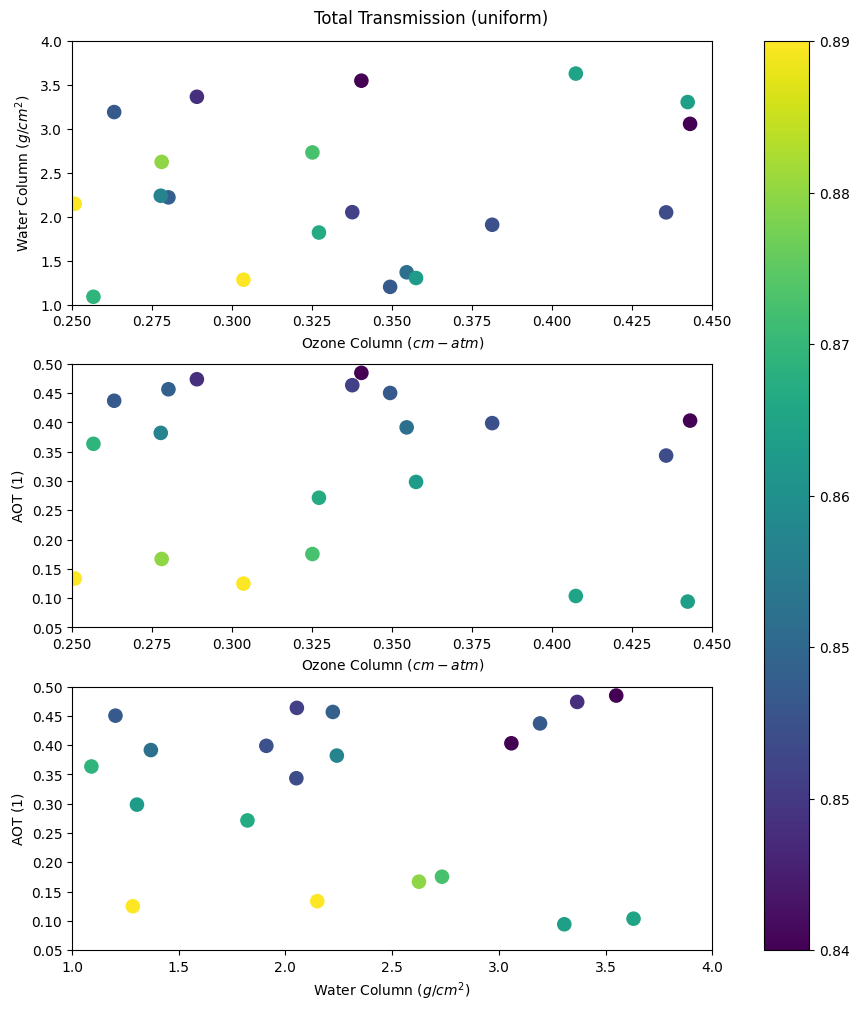

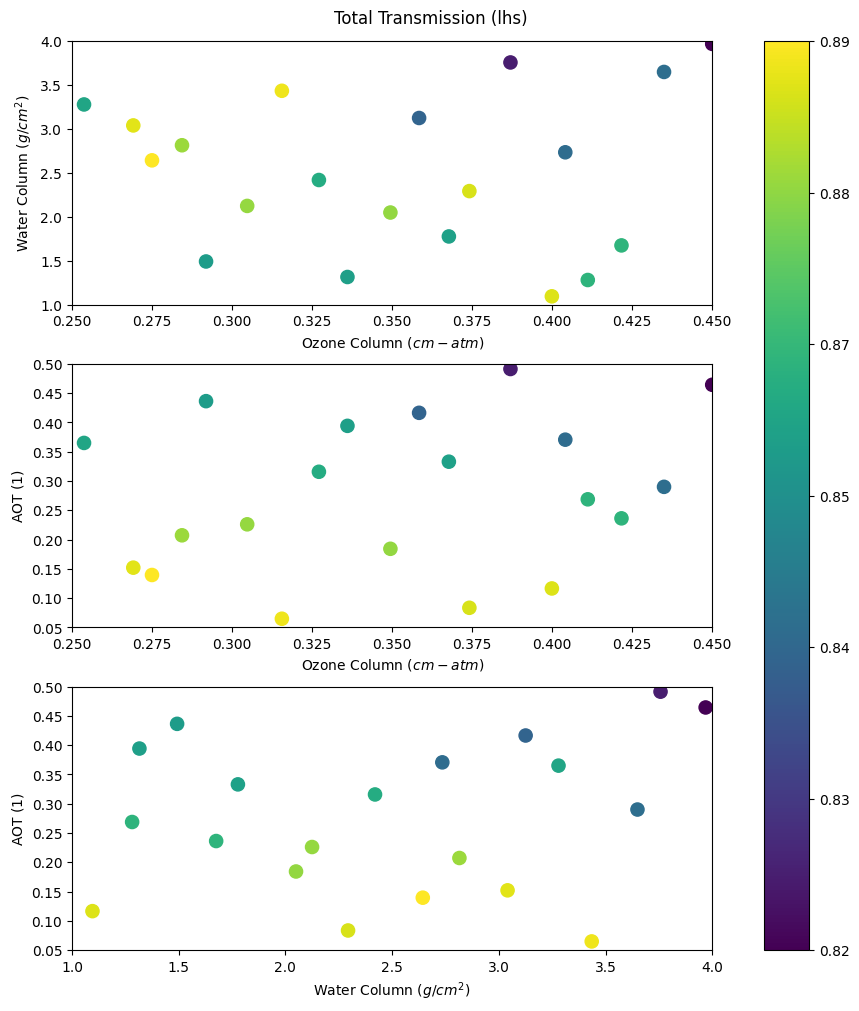

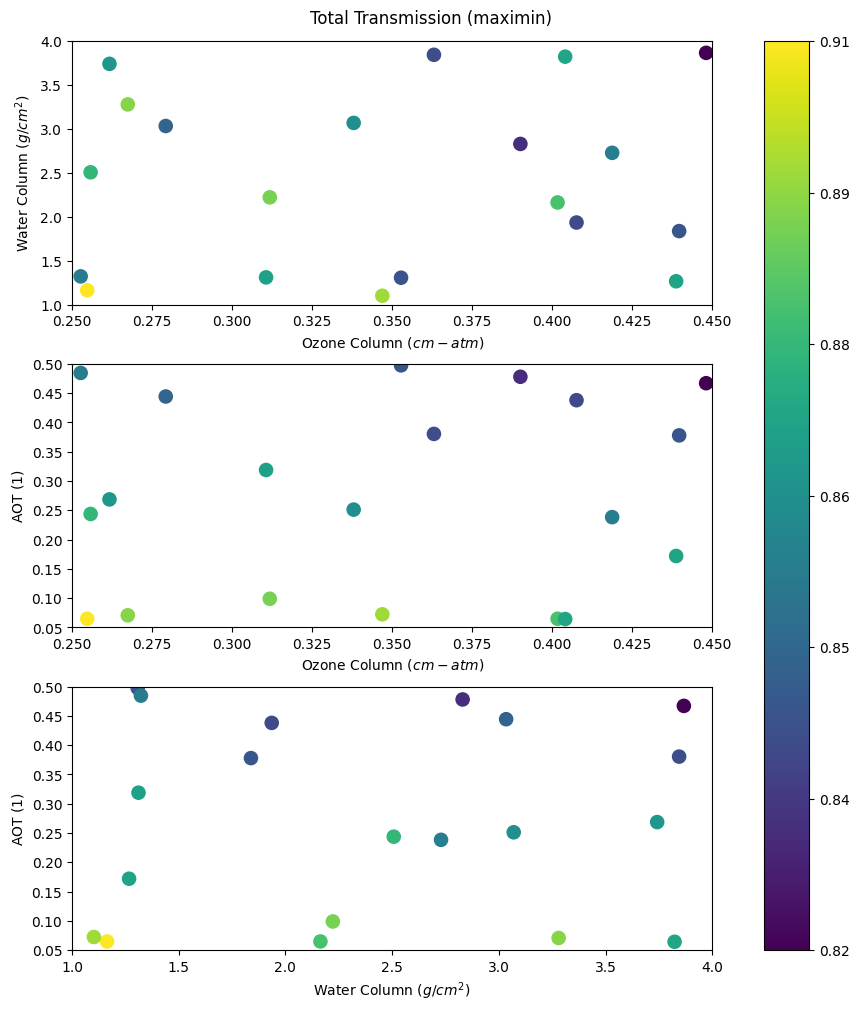

In [183]:
for sampler_name, train_output, input_samples in zip(
    samplers, sampler_train_outputs, sampler_input_samples
):
    # Rescale outputs to [0,1] to use as colormap indices.
    color_source = train_output.values
    color = (color_source - color_source.min()) / (
        color_source.max() - color_source.min()
    )

    param_combos = list(itertools.combinations(INPUT_RANGES.keys(), r=2))
    ncols = math.floor(math.sqrt(len(param_combos)))
    nrows = math.ceil(len(param_combos) / ncols)

    fig, axs = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(8.5, 10), layout="constrained"
    )
    axs = np.asarray(axs)

    for ax, (param_x, param_y) in zip(axs.flat, param_combos):
        art = ax.scatter(input_samples[param_x], input_samples[param_y], c=color, s=90)
        ax.set_xlim(INPUT_RANGES[param_x])
        ax.set_ylim(INPUT_RANGES[param_y])
        ax.set_xlabel(param_rich_name(param_x))
        ax.set_ylabel(param_rich_name(param_y))

    n_ticks = 7
    cbar = fig.colorbar(art, ax=axs, ticks=np.linspace(0, 1, n_ticks))
    cbar.ax.set_yticklabels(
        np.round(np.linspace(color_source.min(), color_source.max(), n_ticks), 2)
    )
    fig.suptitle(f"{train_output.attrs.get('title', 'Output')} ({sampler_name})")

# Train Emulator

## Extract training arrays

In [184]:
sampler_x_train: list[np.ndarray] = [
    np.stack(
        [train_output.coords[parameter].values for parameter in INPUT_RANGES.keys()],
        axis=-1,
    )
    for train_output in sampler_train_outputs
]
sampler_y_train: list[np.ndarray] = [
    train_output.values.reshape(-1, 1) for train_output in sampler_train_outputs
]

## Create GP model

In [185]:
kernel = 1.0 * skl_gp.kernels.RBF()  # + sklearn_gp.kernels.WhiteKernel()
gaussian_process = skl_gp.GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=20,
    alpha=1e-2,
    # alpha=1,
    # Normalize targets to zero means, unit variance.
    normalize_y=True,
)

pipeline = sklearn.pipeline.Pipeline(
    [
        # Rescale input features to [0, 1].
        ("scale", skl_pre.MinMaxScaler()),
        ("gp", gaussian_process),
    ]
)
display(pipeline)
display(pipeline.named_steps["gp"].kernel.hyperparameters)

sampler_models = [skl_base.clone(pipeline) for _ in samplers]

Pipeline(steps=[('scale', MinMaxScaler()),
                ('gp',
                 GaussianProcessRegressor(alpha=0.01,
                                          kernel=1**2 * RBF(length_scale=1),
                                          n_restarts_optimizer=20,
                                          normalize_y=True))])

[Hyperparameter(name='k1__constant_value', value_type='numeric', bounds=array([[1.e-05, 1.e+05]]), n_elements=1, fixed=False),
 Hyperparameter(name='k2__length_scale', value_type='numeric', bounds=array([[1.e-05, 1.e+05]]), n_elements=1, fixed=False)]

## Fit model

In [186]:
for model, x_train, y_train, sampler_name in zip(
    sampler_models, sampler_x_train, sampler_y_train, samplers
):
    model.fit(x_train, y_train)
    print(f"{sampler_name}: {model.named_steps['gp'].kernel_}")

uniform: 13.5**2 * RBF(length_scale=9.79)
lhs: 10.5**2 * RBF(length_scale=7.82)
maximin: 12.3**2 * RBF(length_scale=10.6)


## Plot marginal likelihood surface

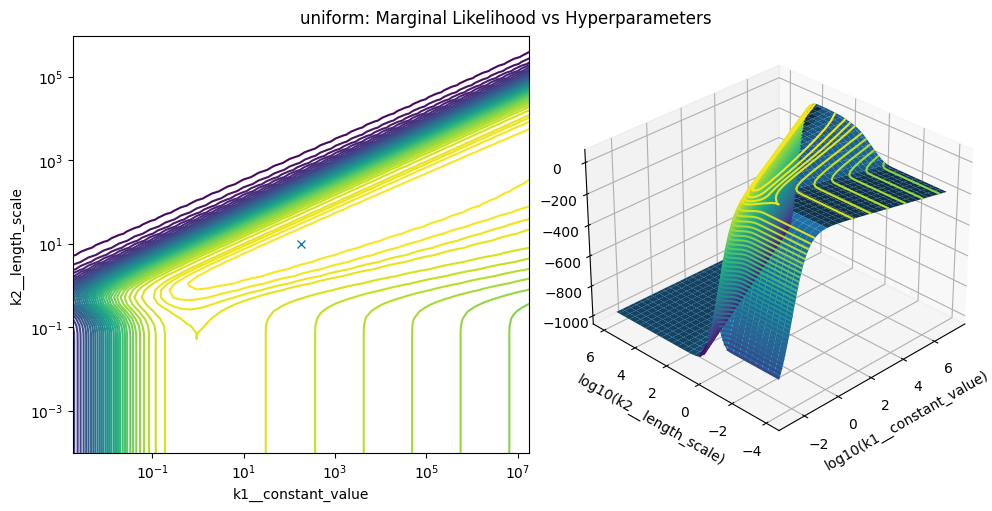

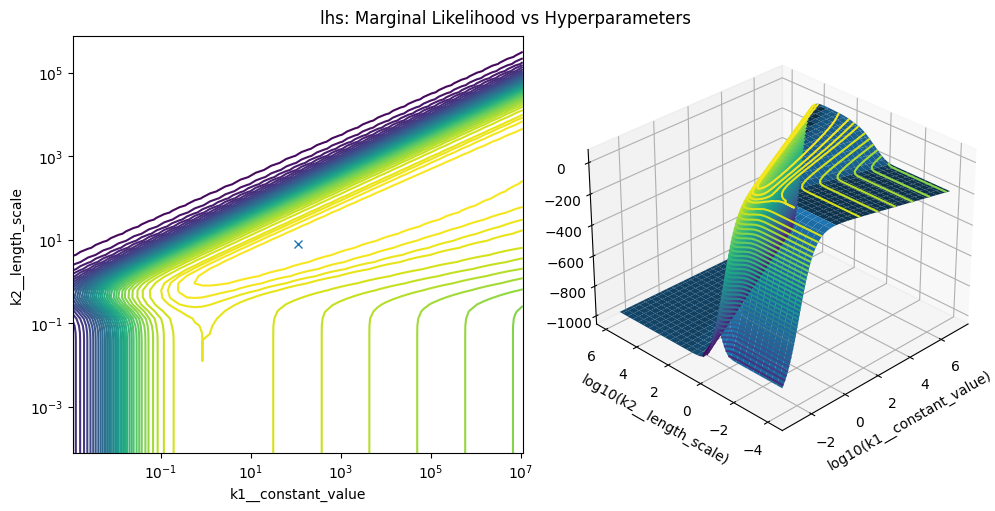

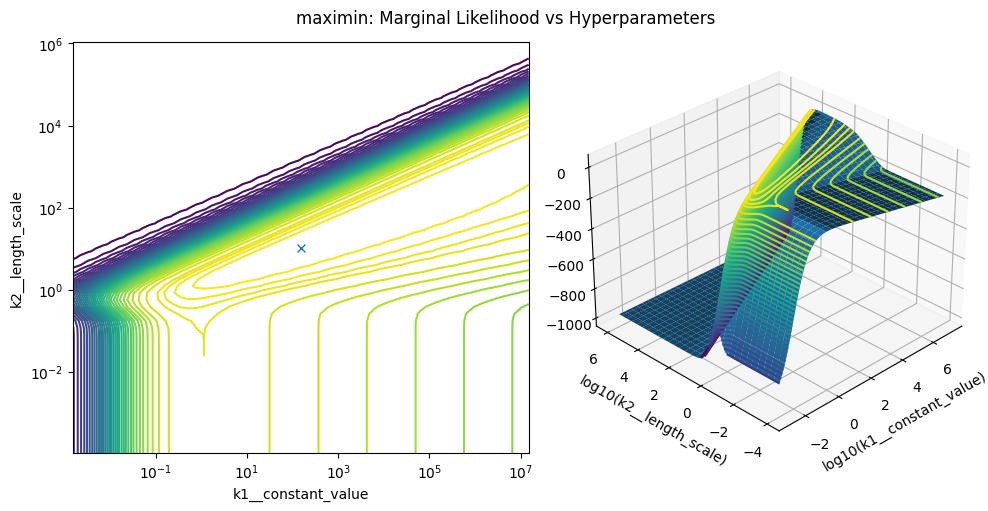

In [187]:
for sampler_name, model in zip(samplers, sampler_models):
    fig = plt.figure(figsize=(10, 5), layout="constrained")
    # Extract fit hyperparameter values.
    gp = model.named_steps["gp"]
    fit_theta = gp.kernel_.theta

    # Indices of the two kernel hyperparameters to vary and plot MLL over.
    plot_hyper_idx = [0, 1]
    plot_hyper_names = [
        gaussian_process.kernel.hyperparameters[idx].name for idx in plot_hyper_idx
    ]

    # Hyperparameter ranges to compute marginal likelihood over.
    # Natural log scaled, and centered about fit hyperparameter values found above.
    log_sweep_0 = np.log(10) * np.linspace(-5, 5, 60) + fit_theta[plot_hyper_idx[0]]
    log_sweep_1 = np.log(10) * np.linspace(-5, 5, 60) + fit_theta[plot_hyper_idx[1]]

    mesh_hyper_0, mesh_hyper_1 = np.meshgrid(log_sweep_0, log_sweep_1)
    # Preallocate array for likelihood at each hyperparameter combination.
    log_marginal_likelihoods = np.zeros(mesh_hyper_0.shape)

    # Compute MLL for each hyperparameter combination.
    for hyper_0, hyper_1, out in np.nditer(
        [mesh_hyper_0, mesh_hyper_1, log_marginal_likelihoods],
        op_flags=[["readonly"], ["readonly"], ["writeonly"]],
    ):
        theta = fit_theta.copy()
        theta[plot_hyper_idx[0]] = hyper_0
        theta[plot_hyper_idx[1]] = hyper_1
        out[...] = gp.log_marginal_likelihood(theta)

    # Plot MLL contours.
    ax = fig.add_subplot(1, 2, 1)
    ax.set_xscale("log")
    ax.set_yscale("log")
    # Pick contour levels. Increase level density near max to better show peaks.
    peak_switch = np.percentile(log_marginal_likelihoods, 85)
    levels = np.hstack(
        (
            np.linspace(log_marginal_likelihoods.min(), peak_switch, 40)[:-1],
            np.linspace(peak_switch, log_marginal_likelihoods.max(), 5),
        )
    )
    # levels = 30
    art = ax.contour(
        np.exp(mesh_hyper_0), np.exp(mesh_hyper_1), log_marginal_likelihoods, levels
    )
    ax.plot(*np.exp(fit_theta), "x")
    ax.set_xlabel(plot_hyper_names[0])
    ax.set_ylabel(plot_hyper_names[1])

    # Plot 3D MLL surface.
    ax = fig.add_subplot(1, 2, 2, projection="3d")
    ax.computed_zorder = False  # Prevent surface from hiding point, https://stackoverflow.com/q/51241367/11082165
    ax.view_init(elev=30, azim=-135)
    zlims = ax.get_zlim()
    ax.scatter(
        [fit_theta[0] / np.log(10)],
        [fit_theta[1] / np.log(10)],
        [gp.log_marginal_likelihood(fit_theta)],
        c="r",
        s=5,
        zorder=2,
    )
    ax.plot_surface(
        mesh_hyper_0 / np.log(10),
        mesh_hyper_1 / np.log(10),
        log_marginal_likelihoods,
        # cmap="coolwarm",
        zorder=1,
    )
    ax.contour(
        mesh_hyper_0 / np.log(10),
        mesh_hyper_1 / np.log(10),
        log_marginal_likelihoods,
        levels=levels,
        zorder=3,
    )

    ax.set_xlabel(f"log10({plot_hyper_names[0]})")
    ax.set_ylabel(f"log10({plot_hyper_names[1]})")
    # ax.set_zlabel("log mll")
    fig.suptitle(f"{sampler_name}: Marginal Likelihood vs Hyperparameters")

# Asses Emulator

## Generate test data

In [188]:
grid_size = 10

dense_input_test = {
    param_name: np.linspace(*param_range, grid_size)
    for param_name, param_range in INPUT_RANGES.items()
}

## Obtain actual sim results for test data

In [189]:
test_sweep = SweepSimulation(
    dense_input_test,
    base=base_inputs,
)

test_sweep_path = pathlib.Path(f"sweep_{sweep_hash(test_sweep)[:10]}.nc")

if test_sweep_path.exists():
    print(f"Loading sweep results from '{test_sweep_path}'")
    test_results = xr.load_dataset(test_sweep_path)
else:
    engine = PySixSEngine()
    runner = ConcurrentExecutor(max_workers=20)

    with alive_progress.alive_bar(test_sweep.sweep_size, force_tty=True) as bar:
        runner.run(test_sweep, engine, step_callback=lambda _: bar())

    test_results = runner.collect_results()
    test_results.to_netcdf(test_sweep_path)
    print(f"Saved sweep results to '{test_sweep_path}'")

test_output = test_results.data_vars[target_output]
display(test_results)

Loading sweep results from 'sweep_2a302fb048.nc'


<xarray.Dataset>
Dimensions:                        (atmosphere.ozone: 10, atmosphere.water: 10,
                                    aerosol_profile.aot: 10)
Coordinates:
  * atmosphere.ozone               (atmosphere.ozone) float64 0.25 ... 0.45
  * atmosphere.water               (atmosphere.water) float64 1.0 1.333 ... 4.0
  * aerosol_profile.aot            (aerosol_profile.aot) float64 0.05 ... 0.5
Data variables:
    transmittance_diffuse_down     (atmosphere.ozone, atmosphere.water, aerosol_profile.aot) float64 ...
    apparent_radiance              (atmosphere.ozone, atmosphere.water, aerosol_profile.aot) float64 ...
    transmittance_total_gas        (atmosphere.ozone, atmosphere.water, aerosol_profile.aot) float64 ...
    transmittance_scattering_down  (atmosphere.ozone, atmosphere.water, aerosol_profile.aot) float64 ...
    transmittance_direct_up        (atmosphere.ozone, atmosphere.water, aerosol_profile.aot) float64 ...
    transmittance_direct_down      (atmosphere.ozone, atmosphere.water, aerosol_profile.aot) float64 ...
    total_transmission             (atmosphere.ozone, atmosphere.water, aerosol_profile.aot) float64 ...
    transmittance_diffuse_up       (atmosphere.ozone, atmosphere.water, aerosol_profile.aot) float64 ...
    transmittance_scattering_up    (atmosphere.ozone, atmosphere.water, aerosol_profile.aot) float64 ...
Attributes:
    version:     0.2.0.dev0+a206f7b
    platform:    CPython 3.10.12 (Linux atricapillus 6.2.0-26-generic #26~22....
    engine:      rtm_wrapper.engines.sixs.PySixSEngine
    base_repr:   Inputs(aerosol_profile=AerosolAOTSingleLayer(aot=<UNSET>, he...
    base_pzb64:  H4sIAI4T8mQC/1VRTU8bMRClKIQFAi2IwpVjkRAXzqhaqWpAIaJ8VByt2exk...
    sim_start:   2023-09-01T12:38:19.685515-04:00
    sim_end:     2023-09-01T12:38:38.074148-04:00

## Extract test arrays

In [190]:
dense_input_meshes = np.meshgrid(
    *dense_input_test.values(),
    indexing="ij",
)

x_test: np.ndarray = np.hstack([mesh.reshape(-1, 1) for mesh in dense_input_meshes])
y_test: np.ndarray = test_output.values.reshape(-1, 1)

## Evaluate model on test data

In [191]:
sampler_pred_means = []
sampler_pred_stds = []
sampler_pred_errors = []
sampler_y_shaped = []

grid_shape = dense_input_meshes[0].shape

for model in sampler_models:
    mean, std = model.predict(x_test, return_std=True)
    sampler_pred_means.append(mean.reshape(grid_shape))
    sampler_pred_stds.append(std.reshape(grid_shape))
    sampler_pred_errors.append((y_test - mean.reshape(-1, 1)).reshape(grid_shape))
    sampler_y_shaped.append(y_test.reshape(grid_shape))

## Compute metrics

In [192]:
for idx, sampler_name in enumerate(samplers):
    print(f"{sampler_name}:")
    rmse = np.sqrt(np.mean(sampler_pred_errors[idx] ** 2))

    abs_error = np.abs(sampler_pred_errors[idx])

    print(f"  RMSE: {rmse:0.2f}")
    print(f"  Avg abs err: {np.mean(abs_error):0.2f}")
    print(f"  Max abs err: {np.max(abs_error):0.2f}")
    print(f"  Avg rel err: {np.mean(abs_error / sampler_y_shaped[idx]):0.2%}")
    print(f"  Max rel err: {np.max(abs_error / sampler_y_shaped[idx]):0.2%}")

uniform:
  RMSE: 0.00
  Avg abs err: 0.00
  Max abs err: 0.00
  Avg rel err: 0.02%
  Max rel err: 0.08%
lhs:
  RMSE: 0.00
  Avg abs err: 0.00
  Max abs err: 0.00
  Avg rel err: 0.03%
  Max rel err: 0.11%
maximin:
  RMSE: 0.00
  Avg abs err: 0.00
  Max abs err: 0.00
  Avg rel err: 0.02%
  Max rel err: 0.08%


## Plot posterior mean, std, error

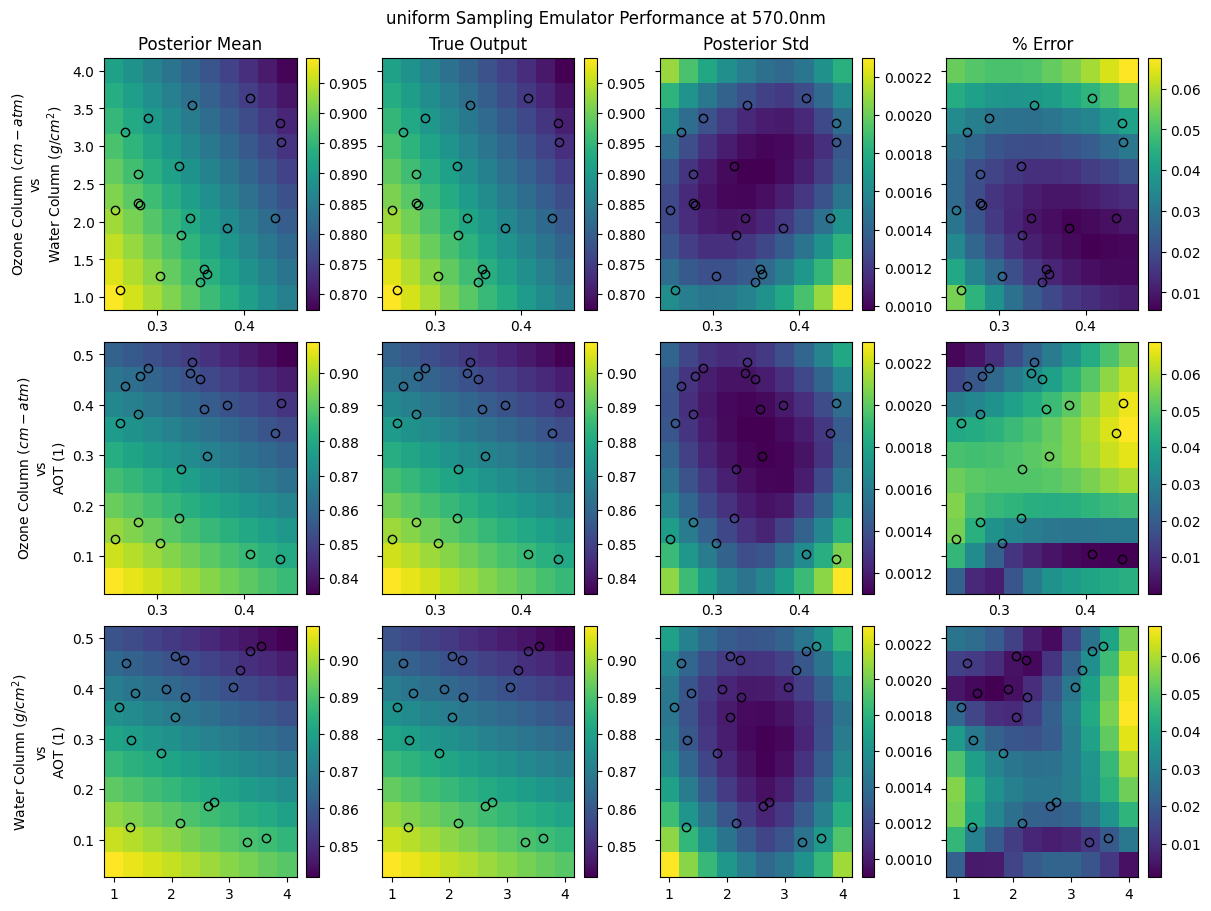

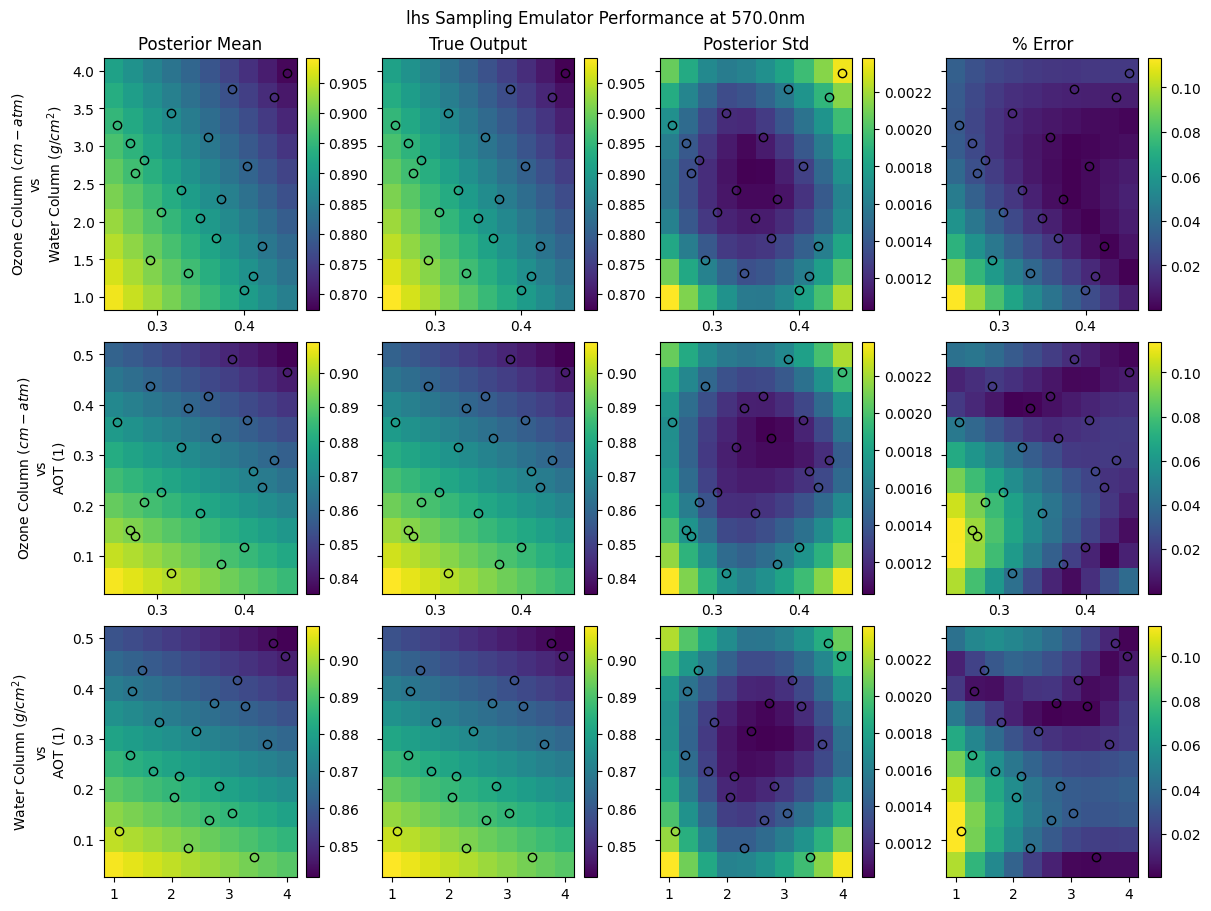

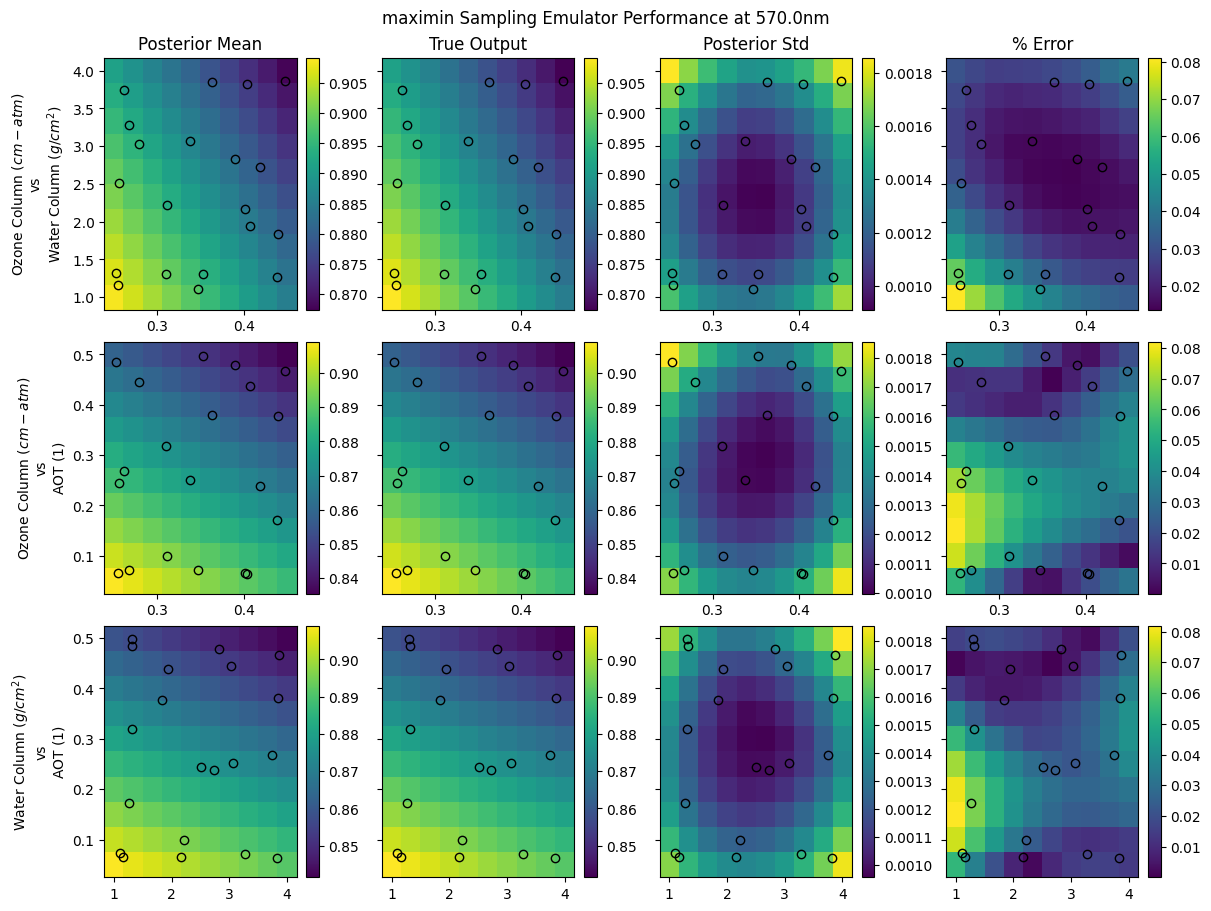

In [193]:
for idx, (sampler_name, input_samples) in enumerate(
    zip(samplers, sampler_input_samples)
):
    param_idx_combos = list(itertools.combinations(range(len(INPUT_RANGES)), r=2))
    param_names = list(INPUT_RANGES.keys())
    fig, axs = plt.subplots(
        nrows=len(param_idx_combos),
        ncols=4,
        figsize=(12, 3 * len(param_idx_combos)),
        sharex="row",
        sharey="row",
        layout="constrained",
    )
    axs = np.asarray(axs)

    for ax_row, (param_x_idx, param_y_idx) in zip(axs, param_idx_combos):
        local_mesh_x, local_mesh_y = np.meshgrid(
            dense_input_test[param_names[param_x_idx]],
            dense_input_test[param_names[param_y_idx]],
            indexing="ij",
        )

        other_dims = tuple(
            i for i in range(len(INPUT_RANGES)) if i not in (param_x_idx, param_y_idx)
        )

        pred_mean_only = sampler_pred_means[idx].max(axis=other_dims)
        y_test_only = sampler_y_shaped[idx].max(axis=other_dims)
        pred_std_only = sampler_pred_stds[idx].max(axis=other_dims)
        pred_error_only = sampler_pred_errors[idx].max(axis=other_dims)

        vmin = min(pred_mean_only.min(), y_test_only.min())
        vmax = max(pred_mean_only.max(), y_test_only.max())

        # Plot predicted mean surface.
        ax = ax_row[0]
        art = ax.pcolormesh(
            local_mesh_x, local_mesh_y, pred_mean_only, vmin=vmin, vmax=vmax
        )
        ax.plot(
            input_samples[param_names[param_x_idx]],
            input_samples[param_names[param_y_idx]],
            "o",
            color="k",
            markerfacecolor="none",
        )

        cbar = fig.colorbar(art)

        # Plot true output surface.
        ax = ax_row[1]
        art = ax.pcolormesh(
            local_mesh_x, local_mesh_y, y_test_only, vmin=vmin, vmax=vmax
        )
        ax.plot(
            input_samples[param_names[param_x_idx]],
            input_samples[param_names[param_y_idx]],
            "o",
            color="k",
            markerfacecolor="none",
        )

        fig.colorbar(art)

        # Plot predicted variance surface.
        ax = ax_row[2]
        art = ax.pcolormesh(local_mesh_x, local_mesh_y, pred_std_only)
        ax.plot(
            input_samples[param_names[param_x_idx]],
            input_samples[param_names[param_y_idx]],
            "o",
            color="k",
            markerfacecolor="none",
        )

        fig.colorbar(art)

        # Plot error surface.
        ax = ax_row[3]
        art = ax.pcolormesh(
            local_mesh_x, local_mesh_y, 100 * np.abs(pred_error_only) / y_test_only
        )
        ax.plot(
            input_samples[param_names[param_x_idx]],
            input_samples[param_names[param_y_idx]],
            "o",
            color="k",
            markerfacecolor="none",
        )

        fig.colorbar(art)

        ax_row[0].set_ylabel(
            f"{param_rich_name(param_names[param_x_idx])}\nvs\n{param_rich_name(param_names[param_y_idx])}"
        )

    axs[0, 0].set_title("Posterior Mean")
    axs[0, 1].set_title("True Output")
    axs[0, 2].set_title("Posterior Std")
    axs[0, 3].set_title("% Error")
    fig.suptitle(
        f"{sampler_name} Sampling Emulator Performance at {WAVELENGTH*1e3:0.1f}nm"
    )